In [1]:
!pip install pandas-datareader==0.10.0

In [2]:
!pip install 'ray[tune]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.2 MB/s eta 0:00:00


In [3]:
# data preprocessing
import datetime
import pandas as pd
import pandas_datareader.data as pdr
from sklearn.preprocessing import MinMaxScaler
import numpy
import seaborn as sns
import matplotlib.pyplot as plt


# machine learning
import torch
from torch.autograd import Variable
import torch.nn as nn

# hyperparameter tuning
import ray
from ray import tune

In [4]:

# Read the CSV file into a DataFrame
csv_file_path = '/content/merged_tsla_stock_data_with_sentiment.csv'
tsla_price_df = pd.read_csv(csv_file_path)

# Rename the column 'compound' to 'Sentiment Score'
tsla_price_df.rename(columns={'compound': 'Sentiment Score'}, inplace=True)

# Display the DataFrame
print(tsla_price_df)

     Unnamed: 0        Open        High         Low       Close     Volume  \
0    2019-12-24   27.890667   28.364668   27.512667   28.350000  120820500   
1    2019-12-26   28.527332   28.898666   28.423332   28.729334  159508500   
2    2019-12-27   29.000000   29.020666   28.407333   28.691999  149185500   
3    2019-12-30   28.586000   28.600000   27.284000   27.646667  188796000   
4    2019-12-31   27.000000   28.086000   26.805332   27.888666  154285500   
..          ...         ...         ...         ...         ...        ...   
544  2022-02-22  278.043335  285.576660  267.033325  273.843323   83288100   
545  2022-02-23  276.809998  278.433319  253.520004  254.679993   95256900   
546  2022-02-24  233.463333  267.493347  233.333328  266.923340  135322200   
547  2022-02-25  269.743347  273.166656  260.799988  269.956665   76067700   
548  2022-02-28  271.670013  292.286682  271.570007  290.143341   99006900   

     Dividends  Stock Splits  Sentiment Score  
0          0.0 

In [5]:
# adding daily returns to stock price data
tsla_price_df['Return'] = tsla_price_df['Close'].pct_change()

In [6]:
# plotting parameters
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

0       28.350000
1       28.729334
2       28.691999
3       27.646667
4       27.888666
          ...    
544    273.843323
545    254.679993
546    266.923340
547    269.956665
548    290.143341
Name: Close, Length: 549, dtype: float64


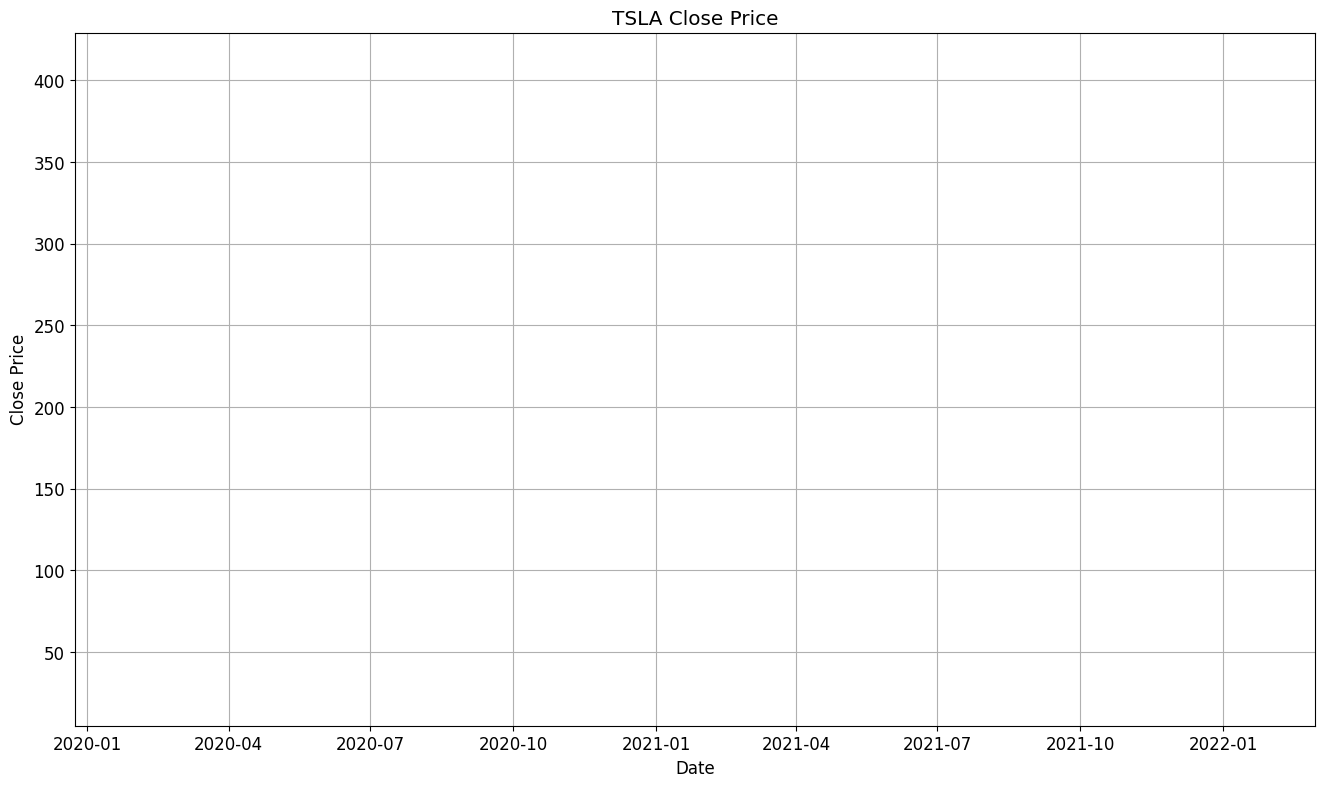

In [9]:

start_time_all = datetime.datetime(2019,12,24)
end_time_all = datetime.datetime(2022, 3, 1)
plt.plot(tsla_price_df.index, tsla_price_df['Close'])
print(tsla_price_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xlim(start_time_all, end_time_all)
plt.title('TSLA Close Price')
plt.show()

In [10]:
# calculating correlation between daily returns and sentiment scores
tsla_price_df['Return'][1:].corr(tsla_price_df['Sentiment Score'][1:])

-0.1550420677505437

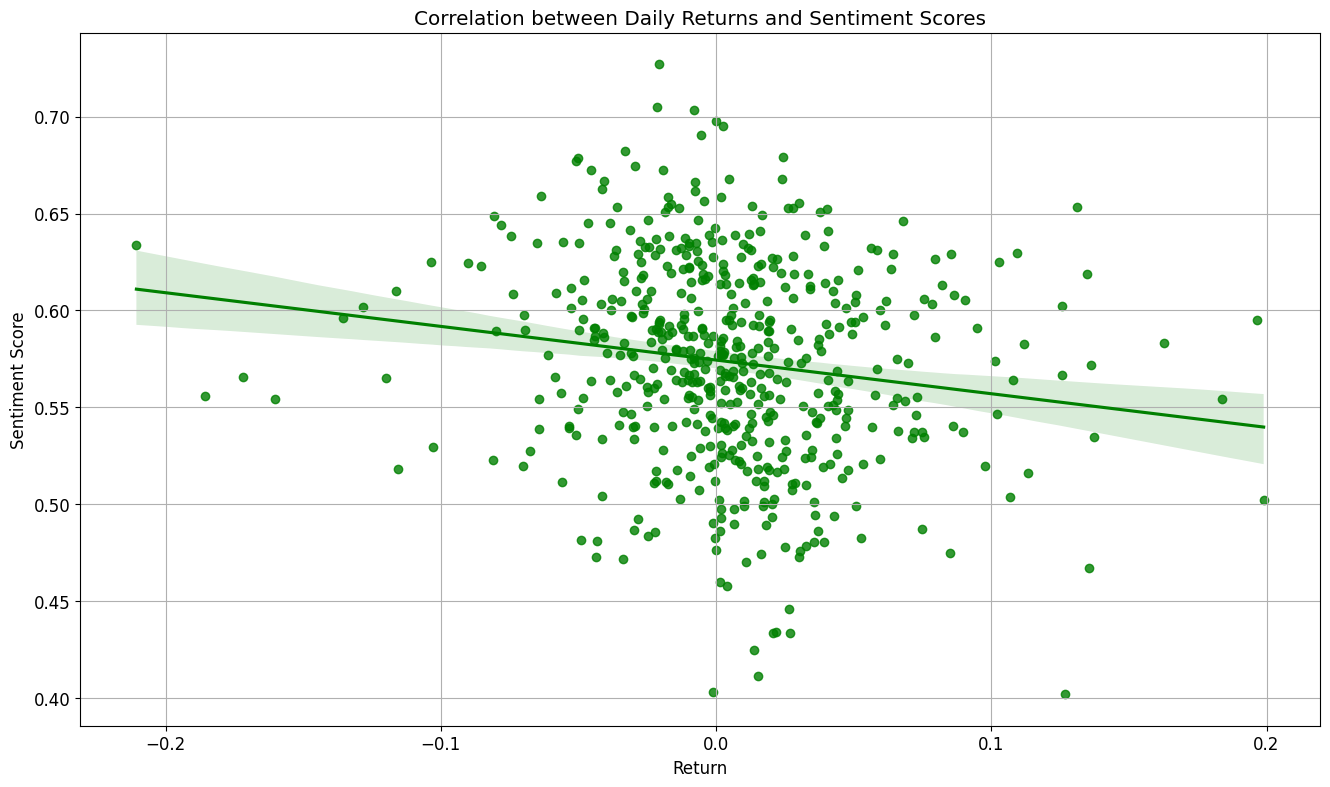

In [11]:
# plotting correlation between daily returns and sentiment scores
sns.regplot(x=tsla_price_df['Return'][1:], y=tsla_price_df['Sentiment Score'][1:], color='g')
plt.title('Correlation between Daily Returns and Sentiment Scores')
plt.show()

In [18]:
# # Read the CSV file into a DataFrame, ensuring the first column is read as dates
# csv_file_path = 'your_csv_file.csv'
# tsla_price_df = pd.read_csv(csv_file_path, parse_dates=[0])

# Rename the unnamed column to 'Date'
tsla_price_df.rename(columns={tsla_price_df.columns[0]: 'Date'}, inplace=True)

# Set the 'Date' column as the index
tsla_price_df.set_index('Date', inplace=True)

# Drop the 'Return' column if it exists
if 'Return' in tsla_price_df.columns:
    tsla_price_df.drop(columns=['Return'], inplace=True)

# Features (High price, Low price, Open price, Volume, Sentiment Score)
X = tsla_price_df.drop(['Close'], axis=1)

# Response (Close price)
y = tsla_price_df['Close']

# Display the features and response DataFrames
print(X)
print(y)

                  Open        High         Low     Volume  Dividends  \
Date                                                                   
2019-12-24   27.890667   28.364668   27.512667  120820500        0.0   
2019-12-26   28.527332   28.898666   28.423332  159508500        0.0   
2019-12-27   29.000000   29.020666   28.407333  149185500        0.0   
2019-12-30   28.586000   28.600000   27.284000  188796000        0.0   
2019-12-31   27.000000   28.086000   26.805332  154285500        0.0   
...                ...         ...         ...        ...        ...   
2022-02-22  278.043335  285.576660  267.033325   83288100        0.0   
2022-02-23  276.809998  278.433319  253.520004   95256900        0.0   
2022-02-24  233.463333  267.493347  233.333328  135322200        0.0   
2022-02-25  269.743347  273.166656  260.799988   76067700        0.0   
2022-02-28  271.670013  292.286682  271.570007   99006900        0.0   

            Stock Splits  Sentiment Score  
Date               

In [15]:
n_split = 400 # where to split training and validation datasets

In [22]:
# Reshape y for scaling
y = y.values.reshape(-1, 1)

# Normalizing datasets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_norm = scaler_X.fit_transform(X)
y_norm = scaler_y.fit_transform(y)

# Split index for training and validation
n_split = len(tsla_price_df[tsla_price_df.index < '2020-10-01'])

# Training using Jan - Sep data
# Validating trained model using Oct - Dec data
X_train = X_norm[:n_split, :]
y_train = y_norm[:n_split, :]

X_val = X_norm[n_split:, :]
y_val = y_norm[n_split:, :]

print('Training Set Shape', X_train.shape, y_train.shape)
print('Validation Set Shape', X_val.shape, y_val.shape)

Training Set Shape (194, 7) (194, 1)
Validation Set Shape (355, 7) (355, 1)


In [23]:
# converting data to tensors
X_train_tensors = Variable(torch.Tensor(X_train))
y_train_tensors = Variable(torch.Tensor(y_train))

X_val_tensors = Variable(torch.Tensor(X_norm))
y_true = numpy.array(y)

# reshaping X dataset
X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                  1, X_train_tensors.shape[1]))
X_val_tensors = torch.reshape(X_val_tensors, (X_val_tensors.shape[0],
                                              1, X_val_tensors.shape[1]))

print('Training Set Shape   ', X_train_tensors.shape, y_train_tensors.shape)
print('Validation Set Shape ', X_val_tensors.shape, y_true.shape)

Training Set Shape    torch.Size([194, 1, 7]) torch.Size([194, 1])
Validation Set Shape  torch.Size([549, 1, 7]) (549, 1)


In [24]:
# selecting gpu
device = torch.device('cuda')

In [25]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size # number of features
        self.hidden_size = hidden_size # number of features in hidden state
        self.num_layers = num_layers # number of stacked LSTM layers
        self.num_classes = num_classes # number of output classes

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes) # fully connected last layer

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0),
                                  self.hidden_size)).to(device) # hidden state
        c0 = Variable(torch.zeros(self.num_layers, x.size(0),
                                  self.hidden_size)).to(device) # internal state
        # propagating input through LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (seq_length, batch_size, hidden_size)
        # decoding hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

In [26]:
# starting ray runtime
ray.init()

2024-06-26 19:24:17,155	INFO worker.py:1770 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.30.0


In [27]:
# checking available resources
ray.cluster_resources()

{'CPU': 2.0,
 'memory': 8020325991.0,
 'object_store_memory': 4010162995.0,
 'node:172.28.0.12': 1.0,
 'node:__internal_head__': 1.0}

In [28]:
# function for calculating MSE (Mean Squared Error)
def calc_mse(y_true, y_hat):
    mse = float(sum((y_true - y_hat) * (y_true - y_hat)) / len(y_hat))
    return mse

In [29]:
# function for fitting and evaluating model using different hyperparameters
def model_fit_eval(config=None, best_config=None, save_model_state=False):
    if best_config is None:
        hidden_size = config['hidden_size']
        num_layers = config['num_layers']
        learning_rate = config['learning_rate']
        # learning rate controls how much to change model in response to estm error each time model weights are updated
        num_epochs = config['num_epochs']
    else:
        hidden_size = best_config['hidden_size']
        num_layers = best_config['num_layers']
        learning_rate = best_config['learning_rate']
        num_epochs = best_config['num_epochs']

    input_size = 6
    num_classes = 1

    model = LSTM_model(input_size, hidden_size, num_layers, num_classes).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # adam optimizer
    # algorithms/methods to change attributes of neural network such as weights and learning rate to reduce losses

    loss_function = torch.nn.MSELoss() # mean-squared error of regression
    # loss function measures how bad model performs: high loss -> low accuracy

    for epoch in range(num_epochs + 1):
        outputs = model.forward(X_train_tensors.to(device)) # forward pass
        optimizer.zero_grad() # calculating gradient, manually setting to 0
        loss = loss_function(outputs, y_train_tensors.to(device)) # obtaining loss
        loss.backward() # calculating loss of loss function
        optimizer.step() # improving from loss, i.e. backprop
        if best_config is not None:
            if epoch % 1000 == 0:
                print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')

    # saving model state
    if save_model_state:
        torch.save(model.state_dict(), '4-model-state.pth')

    # loading model state
    # model = LSTM_model(*args, **kwargs)
    # model.load_state_dict(torch.load(PATH))
    # model.eval()

    # predicting response from model
    y_hat = model(X_val_tensors.to(device)) # forward pass
    y_hat = y_hat.data.detach().cpu().numpy() # numpy conversion
    y_hat = scaler.inverse_transform(y_hat) # inverse transformation

    if best_config is None:
        mse = calc_mse(y_true, y_hat)
        tune.report(mse=mse)
    else:
        return y_hat

In [ ]:
# USE SSA HERE!!

# # using grid search to get best hyperparameters
# analysis = tune.run(
#     model_fit_eval,
#     config={'hidden_size': tune.grid_search([2, 3, 5]),
#             'learning_rate': tune.grid_search([0.0005, 0.001, 0.002]),
#             'num_epochs': tune.grid_search([2000, 4000, 8000]),
#             'num_layers': tune.grid_search([1, 2, 4])},
#     resources_per_trial={'cpu': 2, 'gpu': 1}) # leveraging all resources

#   # visualizing hyperparameter tuning results
# %load_ext tensorboard
# %tensorboard --logdir ~/ray_results

# # best hyperparameters
# best_trial = analysis.get_best_trial(metric='mse', mode='min', scope='all')
# min_mse = best_trial.metric_analysis['mse']['avg']
# print(f'Min MSE: {min_mse}')
# best_trial_config = best_trial.config
# print(f'Best trial config: {best_trial_config}')

# # training model using best hyperparameters
# best_trial_config['num_epochs'] = 10000 # increasing num of epochs
# y_hat = model_fit_eval(best_config=best_trial_config, save_model_state=True)

# # shutting down ray runtime
# ray.shutdown()


In [35]:
# function for plotting actual and predicted Adj Close price
y_hat=[]
def plt_graph(start_time, end_time, period, val_line=False):
    # plotting actual Adj Close price
    plt.plot(tsla_price_df.index, y_true, label='Actual Price')
    # plotting predicted Adj Close price
    plt.plot(tsla_price_df.index, y_hat, label='Pred Price')
    if val_line:
        plt.axvline(x=start_time_val, c='r', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.xlim(start_time, end_time)
    plt.title(f'{period} Period')
    plt.legend()
    plt.show()

In [ ]:
# # plotting all period
# period = 'All'
# plt_graph(start_time_all, end_time_all, period, True)

In [38]:
def calc_mse(y_true, y_hat):
    if len(y_true) != len(y_hat):
        raise ValueError("Length of y_true and y_hat must be the same.")

    mse = np.mean((y_true - y_hat) ** 2)
    return mse

In [ ]:
# mse = calc_mse(y_true, y_hat)                     ### AFTER IMPLEMENTING SSA
# print(f'MSE ({period}): {mse}')

In [ ]:
# # plotting training period
# period = 'Training'
# plt_graph(start_time_all, end_time_train, period)

In [ ]:
# mse = calc_mse(y_true[:n_split], y_hat[:n_split])
# print(f'MSE ({period}): {mse}')

In [ ]:
# # plotting validation period
# period = 'Validation'
# plt_graph(start_time_val, end_time_all, period)

In [ ]:
# mse = calc_mse(y_true[n_split:], y_hat[n_split:])
# print(f'MSE ({period}): {mse}')